# Redes Neurais Artificiais 2020.1 -- Projeto Prático 3.4

**Disciplina**: Redes Neurais Artificiais 2020.1  
**Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)<br/>
**Github**: http://github.com/elloa  
  - Dayvson dos Santos Silva<br/>
    **Email**: ddss.snf19@uea.edu.br<br/>
    **GitHub**: https://github.com/userddssilva<br/>
  - Hiago Oliveira de Jesus<br/>
    **Email**: hodj.lic@uea.edu.br<br/>
    **GitHub**: https://github.com/HiagoOliver<br/>     
        

Levando em conta a base de dados **_Forest Cover Type_**, esta terceira parte do Projeto Prático 3 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Busca em Grade

Uma maneira padrão de escolher os parâmetros de um modelo de Machine Learning é por meio de uma busca em grade via força bruta. O algoritmo da busca em grade é dado como segue:

1. Escolha a métrica de desempenho que você deseja maximizar  
2. Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você deseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  
3. Defina a grade de busca, a qual é dada como o produto cartesiano de cada parâmetro a ser testado. Por exemplo, para os arrays [50, 100, 1000] e [10, 15], tem-se que a grade é [(50,10), (50,15), (100,10), (100,15), (1000,10), (1000,15)].
4. Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)
5. Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Por que esta abordagem funciona? Porque a busca em grade efetua uma pesquisa extensiva sobre as possíveis combinações de valores para cada um dos parâmetros a serem ajustados. Para cada combinação, ela estima a performance do modelo em dados novos. Por fim, o modelo com melhor métrica de desempenho é escolhido. Tem-se então que este modelo é o que melhor pode vir a generalizar mediante dados nunca antes vistos.

## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

Nesta busca em grande, contemple a utilização do objeto [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Bibliotecas

In [53]:
import warnings
warnings.filterwarnings('ignore')

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prettytable import PrettyTable

from itertools import product

from joblib import dump, load

from sklearn.model_selection import KFold

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix

## Base de Dados

In [2]:
full_database = pd.read_csv('../database/covtype.csv')
full_database

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [71]:
frames = []
for i in range(1,8):
    frames.append(full_database[full_database.Cover_Type == i][:1000])
database = pd.concat(frames, ignore_index=True, join='outer')
database

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2699,347,3,0,0,2096,213,234,159,6853,...,0,0,0,0,0,0,0,0,0,1
1,2739,323,25,85,43,3118,149,205,192,6219,...,0,0,0,0,0,0,0,0,0,1
2,2696,72,2,30,0,3271,222,234,149,6071,...,0,0,0,0,0,0,0,0,0,1
3,2722,315,24,30,19,3216,148,212,200,6132,...,0,0,0,0,0,0,0,0,0,1
4,2919,13,13,90,6,5321,207,214,142,4060,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,3355,194,9,67,0,4592,219,248,163,4274,...,0,0,0,0,0,0,0,0,0,7
6996,3360,15,11,0,0,4631,210,217,143,4228,...,0,0,0,0,0,0,0,0,0,7
6997,3377,3,19,551,188,4093,191,201,144,3649,...,0,0,0,0,0,0,0,0,1,7
6998,3377,357,18,577,192,4039,189,205,151,3606,...,0,0,0,0,0,0,0,0,1,7


## Busca em Grade

- Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você deseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  

In [12]:
# Definindo o algoritmo de Machine Learning
algoritmo = MLPClassifier()

# Definindo os parâmetros
parametros = {'hidden_layer_sizes': [(16, 6), (19, 6)],    # Camadas
              'activation': ['tanh'],             # Funções de ativação
              'solver': ['sgd'],                  # Otimizadores
              'max_iter': [100, 200],             # Épocas
              'shuffle': [True],                  # Condição para embaralhar as amostras em cada iteração
              'n_iter_no_change': [5, 2]}         # Máximo de épocas sem melhorias na rede
            

In [63]:
def produto(parametros):
    params = list (dict(zip(parametros.keys(), values)) for values in product(*parametros.values()))
    for param in params:
        for key, value in param.items():
            param[key] = [value]
    return params
param = produto(parametros)

table = PrettyTable(['Camadas', 'Ativação', 'Otimizador', 'Épocas','Randômico', 'N. sem alter.'])
table.padding_width = 1
for p in param:
    table.add_row([
        p['hidden_layer_sizes'],
        p['activation'],
        p['solver'],
        p['max_iter'],
        p['shuffle'],
        p['n_iter_no_change']
    ])
print(table)

+-----------+----------+------------+--------+-----------+---------------+
|  Camadas  | Ativação | Otimizador | Épocas | Randômico | N. sem alter. |
+-----------+----------+------------+--------+-----------+---------------+
| [(16, 6)] | ['tanh'] |  ['sgd']   | [100]  |   [True]  |      [5]      |
| [(16, 6)] | ['tanh'] |  ['sgd']   | [100]  |   [True]  |      [2]      |
| [(16, 6)] | ['tanh'] |  ['sgd']   | [200]  |   [True]  |      [5]      |
| [(16, 6)] | ['tanh'] |  ['sgd']   | [200]  |   [True]  |      [2]      |
| [(19, 6)] | ['tanh'] |  ['sgd']   | [100]  |   [True]  |      [5]      |
| [(19, 6)] | ['tanh'] |  ['sgd']   | [100]  |   [True]  |      [2]      |
| [(19, 6)] | ['tanh'] |  ['sgd']   | [200]  |   [True]  |      [5]      |
| [(19, 6)] | ['tanh'] |  ['sgd']   | [200]  |   [True]  |      [2]      |
+-----------+----------+------------+--------+-----------+---------------+


- Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)

Usando cross-validation

In [72]:
result_list = []

for p in param:
    net_results = {
        'fscores': [], 
        'accuracies': [],
        'precision': [],
        'net': None
    }

    net = MLPClassifier(
        hidden_layer_sizes=p['hidden_layer_sizes'][0],
        activation=p['activation'][0],
        solver=p['solver'][0],
        max_iter=p['max_iter'][0],
        shuffle=p['shuffle'][0],
        n_iter_no_change=p['n_iter_no_change'][0]
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for index_train, index_test in kf.split(database):
        # Alocando os atributos preditores na variável X
        X_train = database.iloc[index_train,:-1]

        # Alocando o atributo alvo na variável y
        y_train = database.iloc[index_train,-1:]

        # Alocando os atributos preditores na variável X
        X_test = database.iloc[index_test,:-1]

        # Alocando o atributo alvo na variável y
        y_test = database.iloc[index_test,-1:]

        net.fit(X_train, y_train)

        y_pred = net.predict(X_test)

        net_results['fscores'].append(f1_score(y_test, y_pred, average='macro'))
        net_results['accuracies'].append(accuracy_score(y_test, y_pred))
        net_results['precision'].append(precision_score(y_test, y_pred, average='macro'))

    net_results['net'] = net
    result_list.append(net_results)

- Visualizando o valor das médias das metrica para cada fold testado no cross-validation e do desvio padrão.

In [106]:
table = PrettyTable(["Rede", "MEAN F-score", "STD F-score", "MEAN acur", "STD accur", "MEAN prec", "STD prec"])        
table.padding_width = 1
i = 1
for item in result_list:
    table.add_row([
        i,
        round(np.mean(item['fscores']), 4),
        round(np.std(item['fscores']), 4),
        round(np.mean(item['accuracies']), 4),
        round(np.std(item['accuracies']), 4),
        round(np.mean(item['precision']), 4),
        round(np.std(item['precision']), 4)
    ])
    i += 1
print(table)

+------+--------------+-------------+-----------+-----------+-----------+----------+
| Rede | MEAN F-score | STD F-score | MEAN acur | STD accur | MEAN prec | STD prec |
+------+--------------+-------------+-----------+-----------+-----------+----------+
|  1   |    0.1663    |    0.056    |   0.2481  |   0.0311  |   0.1664  |  0.0762  |
|  2   |    0.1811    |    0.0548   |   0.2587  |   0.0474  |   0.198   |  0.0511  |
|  3   |    0.2052    |    0.0459   |   0.2756  |   0.0467  |   0.3012  |  0.0838  |
|  4   |    0.1394    |    0.0475   |   0.2213  |   0.0532  |   0.1681  |  0.1194  |
|  5   |    0.2114    |    0.0652   |   0.256   |   0.0444  |   0.2751  |  0.0953  |
|  6   |    0.2032    |    0.0308   |   0.2771  |   0.0321  |   0.2157  |  0.0545  |
|  7   |    0.1893    |    0.0728   |   0.2739  |   0.0482  |   0.2163  |  0.1069  |
|  8   |    0.2255    |    0.0351   |   0.282   |   0.0231  |   0.2703  |  0.054   |
+------+--------------+-------------+-----------+-----------+----

Usando Holdout

In [93]:
# Alocando os atributos preditores na variável X
X = database.iloc[:,:-1]

# Alocando o atributo alvo na variável y
y = database.iloc[:,-1:]

# Definindo a partição holdout 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)


result_list_2 = []

for p in param:
    net_results = {
        'fscores':'' , 
        'accuracies':'',
        'precision':'',
        'net': ''
    }

    net = MLPClassifier(
        hidden_layer_sizes=p['hidden_layer_sizes'][0],
        activation=p['activation'][0],
        solver=p['solver'][0],
        max_iter=p['max_iter'][0],
        shuffle=p['shuffle'][0],
        n_iter_no_change=p['n_iter_no_change'][0]
    )

    # Buscando a melhor configuração de parâmetros
    net.fit(X_train, y_train)

    y_pred = net.predict(X_test)

    # Calculando a métrica de avaliação
    net_results['fscores'] = (f1_score(y_test, y_pred, average='macro'))
    net_results['accuracies'] = (precision_score(y_test, y_pred, average='macro'))
    net_results['precision'] = (accuracy_score(y_test, y_pred))
    net_results['net'] = net
    result_list_2.append(net_results)
    

- Visualizando as métricas para o conjunto de testes anterior

In [95]:
table = PrettyTable(["Rede", "F-score", "Acurácia", "Precisão"])        
table.padding_width = 1
i = 1
for item in result_list_2:
    table.add_row([
        i,
        round(item['fscores'], 4),
        round(item['accuracies'], 4),
        round(item['precision'], 4),
    ])
    i += 1
print(table)

+------+---------+----------+----------+
| Rede | F-score | Acurácia | Precisão |
+------+---------+----------+----------+
|  1   |  0.1843 |  0.1795  |  0.2386  |
|  2   |  0.1746 |  0.361   |  0.2552  |
|  3   |  0.1229 |  0.0876  |  0.2057  |
|  4   |  0.2168 |  0.271   |  0.2786  |
|  5   |  0.2396 |  0.281   |  0.3243  |
|  6   |  0.0941 |  0.0664  |  0.2043  |
|  7   |  0.2227 |  0.2562  |  0.2752  |
|  8   |  0.1114 |  0.2203  |  0.2338  |
+------+---------+----------+----------+


- Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Para o experimento com cross-validation

In [108]:
table = PrettyTable(["Rede", "MEAN F-score", "STD F-score", "MEAN acur", "STD accur", "MEAN prec", "STD prec"])        
table.padding_width = 1
item = result_list[7]
table.add_row([
    8,
    round(np.mean(item['fscores']), 4),
    round(np.std(item['fscores']), 4),
    round(np.mean(item['accuracies']), 4),
    round(np.std(item['accuracies']), 4),
    round(np.mean(item['precision']), 4),
    round(np.std(item['precision']), 4)
])
print(table)

+------+--------------+-------------+-----------+-----------+-----------+----------+
| Rede | MEAN F-score | STD F-score | MEAN acur | STD accur | MEAN prec | STD prec |
+------+--------------+-------------+-----------+-----------+-----------+----------+
|  8   |    0.2255    |    0.0351   |   0.282   |   0.0231  |   0.2703  |  0.054   |
+------+--------------+-------------+-----------+-----------+-----------+----------+


In [109]:
table = PrettyTable(['Camadas', 'Ativação', 'Otimizador', 'Épocas','Randômico', 'N. sem alter.'])
table.padding_width = 1
p = param[7]
table.add_row([
    p['hidden_layer_sizes'],
    p['activation'],
    p['solver'],
    p['max_iter'],
    p['shuffle'],
    p['n_iter_no_change']
])
print(table)

+-----------+----------+------------+--------+-----------+---------------+
|  Camadas  | Ativação | Otimizador | Épocas | Randômico | N. sem alter. |
+-----------+----------+------------+--------+-----------+---------------+
| [(19, 6)] | ['tanh'] |  ['sgd']   | [200]  |   [True]  |      [2]      |
+-----------+----------+------------+--------+-----------+---------------+


Para o experimento com o Holdout

In [112]:
table = PrettyTable(["Rede", "F-score", "Acurácia", "Precisão"])        
table.padding_width = 1
item =  result_list_2[4]
table.add_row([
    5,
    round(item['fscores'], 4),
    round(item['accuracies'], 4),
    round(item['precision'], 4),
])
print(table)

+------+---------+----------+----------+
| Rede | F-score | Acurácia | Precisão |
+------+---------+----------+----------+
|  5   |  0.2396 |  0.281   |  0.3243  |
+------+---------+----------+----------+


In [113]:
table = PrettyTable(['Camadas', 'Ativação', 'Otimizador', 'Épocas','Randômico', 'N. sem alter.'])
table.padding_width = 1
p = param[5]
table.add_row([
    p['hidden_layer_sizes'],
    p['activation'],
    p['solver'],
    p['max_iter'],
    p['shuffle'],
    p['n_iter_no_change']
])
print(table)

+-----------+----------+------------+--------+-----------+---------------+
|  Camadas  | Ativação | Otimizador | Épocas | Randômico | N. sem alter. |
+-----------+----------+------------+--------+-----------+---------------+
| [(19, 6)] | ['tanh'] |  ['sgd']   | [100]  |   [True]  |      [2]      |
+-----------+----------+------------+--------+-----------+---------------+


## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

```
1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  
```

In [117]:
# Leitura das arquiteturas
arquiteturas = [load('../redes/rede{0}.joblib'.format(i)) for i in range(1, 7)]

# metricas de testes das redes
net_metrics = [
    (0.734, 0.529),
    (0.728, 0.542),
    (0.724, 0.478),
    (0.745, 0.578),
    (0.743, 0.568),
    (0.742, 0.516)
]

    Redes treinadas sem atributos categóricos

In [60]:
table = PrettyTable(['Rede', 'Camadas', 'Ativação', 'Épocas', 'Otimizador', 'Neurônios', 'Acurácia', 'F-score'])
table.padding_width = 1
for i in range(3):
   table.add_row([
       'Rede {0}'.format(i), 
        arquiteturas[i].hidden_layer_sizes,
        arquiteturas[i].activation,
        arquiteturas[i].max_iter,
        arquiteturas[i].solver,
        np.sum(arquiteturas[i].hidden_layer_sizes),
        net_metrics[i][0],
        net_metrics[i][1]
   ])
print(table)

+--------+---------+----------+--------+------------+-----------+----------+---------+
|  Rede  | Camadas | Ativação | Épocas | Otimizador | Neurônios | Acurácia | F-score |
+--------+---------+----------+--------+------------+-----------+----------+---------+
| Rede 0 | (9, 10) |   tanh   |  200   |    adam    |     19    |  0.734   |  0.529  |
| Rede 1 |  (13,)  |   tanh   |  150   |    adam    |     13    |  0.728   |  0.542  |
| Rede 2 | (9, 10) |   tanh   |  100   |    sgd     |     19    |  0.724   |  0.478  |
+--------+---------+----------+--------+------------+-----------+----------+---------+


    Redes treinadas com atributos categóricos

In [118]:
table = PrettyTable(['Rede', 'Camadas', 'Ativação', 'Épocas', 'Otimizador', 'Neurônios', 'Acurácia', 'F-score'])
table.padding_width = 1
for i in range(3, 6):
   table.add_row([
       'Rede {0}'.format(i+4), 
        arquiteturas[i].hidden_layer_sizes,
        arquiteturas[i].activation,
        arquiteturas[i].max_iter,
        arquiteturas[i].solver,
        np.sum(arquiteturas[i].hidden_layer_sizes),
        net_metrics[i][0],
        net_metrics[i][1]
   ])
print(table)

+--------+---------+----------+--------+------------+-----------+----------+---------+
|  Rede  | Camadas | Ativação | Épocas | Otimizador | Neurônios | Acurácia | F-score |
+--------+---------+----------+--------+------------+-----------+----------+---------+
| Rede 7 |  (25,)  | logistic |  200   |    adam    |     25    |  0.745   |  0.578  |
| Rede 8 |  (25,)  | logistic |  100   |    adam    |     25    |  0.743   |  0.568  |
| Rede 9 | (19, 6) |   tanh   |  150   |    sgd     |     25    |  0.742   |  0.516  |
+--------+---------+----------+--------+------------+-----------+----------+---------+


- Número de repetições que a equipe conseguiu realizar para verificar os resultados foi de 10 repetições

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

In [14]:
# Definindo os hiperparâmetros
hiperparametros = { 'solver': ['sgd', 'adam'],            
                    'batch_size': [100, 150, 200],                      
                    'learning_rate': ['constant', 'invscaling', 'adaptive'],                    
                    'n_iter_no_change': [5, 3],
                    'max_iter': [100, 200, 300]} 

- Fazendo uma busca em grade com as arquiteturas dos experimentos anteriores

In [16]:
# Definindo a métrica como F1-Score
metrica = 'f1'

# Melhores hiperparâmetros para cada arquitetura
bests1 = []

# Alocando os atributos preditores na variável X
X = database.iloc[:,:-1]

# Alocando o atributo alvo na variável y
y = database.iloc[:,-1:]

for i in range(0,6):
    print('GridSearch com a arquitetura:', i)

    # Definindo a busca em grade para as arquitetura 4, 5 e 6
    search = GridSearchCV(arquiteturas[i], hiperparametros, scoring='%s_macro' % metrica, cv=5)
    
    # Buscando a melhor configuração de hiperparâmetros
    search.fit(X_train, y_train)

    # Salvando os melhores hiperparâmetros de cada arquitetura
    bests1.append(search.best_params_)

3
4
5


- Melhores hiperparâmetros com os atributos categóricos

In [17]:
for i in range(3,6):
    print('Rede {0}'.format(i+1), bests1[i-3])

Rede 4 {'batch_size': [500], 'learning_rate': ['constant'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}
Rede 5 {'batch_size': [500], 'learning_rate': ['constant'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}
Rede 6 {'batch_size': [500], 'learning_rate': ['invscaling'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}


- Busca em Grade sem os atributos categóricos

In [18]:
database2 = database_min.copy()

# Removendo os atributos categóricos
columns_to_drop = []
for column in list(database2.columns):
    column_search = re.search('Soil_Type|Wilderness_Area', column)
    if column_search:
        columns_to_drop.append(column)
database2.drop(columns=columns_to_drop, axis=1, inplace=True)

In [19]:
# Definindo a métrica como F1-Score
metrica = 'f1'

# Combinações dos hiperparâmetros
grades = produto(hiperparametros)

# Melhores hiperparâmetros para cada arquitetura
bests2 = []

# Alocando os atributos preditores na variável X
X = database2.iloc[:,:-1]

# Alocando o atributo alvo na variável y
y = database2.iloc[:,-1:]

for i in range(0,3):
    print(i)

    # Definindo a busca em grade para as arquitetura 1, 2 e 3
    search = GridSearchCV(arquiteturas[i], grades, scoring='%s_macro' % metrica)
    
    # Definindo a partição holdout 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # Buscando a melhor configuração de hiperparâmetros
    search.fit(X_train, y_train)

     # Salvando os melhores hiperparâmetros de cada arquitetura
    for key, value in search.best_params_.items():
        search.best_params_[key] = [value]
    bests2.append(search.best_params_)

0
1
2


- Melhores hiperparâmetros sem os atributo categóricos

In [20]:
for i in range(0,3):
    print('Rede {0}'.format(i+1), bests2[i-3])

Rede 1 {'batch_size': [500], 'learning_rate': ['constant'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}
Rede 2 {'batch_size': [500], 'learning_rate': ['constant'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}
Rede 3 {'batch_size': [500], 'learning_rate': ['adaptive'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}


## Validação Cruzada k-fold

Na elaboração da busca em grid, vamos avaliar os modelos propostos segundo uma estratégia de validação cruzada ainda não explorada até o momento: a validação cruzada k-fold. Segundo a mesma, o conjunto de dados é particionado em k partes: a cada iteração, separa-se uma das partes para teste e o modelo é treinado com as k-1 partes remanescentes. Valores sugestivos de k na literatura são k = 3, 5 ou 10, pois o custo computacional desta validação dos modelos é alto. A métrica de desempenho é resultante da média dos desempenhos nas k iterações. A figura a seguir ilustra a ideia desta avaliação

<img src = "https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600></img>

Considerando a métrica de desempenho F1-Score, considere a validação cruzada 5-fold para aferir os resultados da busca em grande anterior.

- Validação cruzada com atributos categóricos

In [21]:
metrica = 'f1'

# Desempenho de cada arquitetura
fscore = dict()

for i in range(1,7):
    fscore.setdefault('rede{0}'.format(i), [])

In [22]:
# Definindo o número de folds
k_folds = KFold(5)

# Alocando os atributos preditores na variável X
X = database.iloc[:,:-1]

# Alocando o atributo alvo na variável y
y = database.iloc[:,-1:]

rede = 4

# Validação Cruzada com os atributos categóricos
for params, arquitetura in zip(bests1, arquiteturas[3:6]):
    print(params)
    print('rede ', rede)
    
    search = GridSearchCV(arquitetura, params, scoring='%s_macro' % metrica)
    
    fscores = []
    
    for k, (train, test) in enumerate(k_folds.split(X, y)):
        
        print('k = {0}'.format(k+1))

        X_train = X.iloc[train]
        y_train = y.iloc[train]
        
        
        search.fit(X_train, y_train)
        
        X_test = X.iloc[test]
        y_test = y.iloc[test]


        y_pred = search.predict(X_test)

        fscores.append(f1_score(y_pred, y_test, average='macro'))

    fscore['rede'+str(rede)].append((fscores, search.best_params_, arquitetura))
    rede += 1

{'batch_size': [500], 'learning_rate': ['constant'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}
rede  4
k = 1
k = 2
k = 3
k = 4
k = 5
{'batch_size': [500], 'learning_rate': ['constant'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}
rede  5
k = 1
k = 2
k = 3
k = 4
k = 5
{'batch_size': [500], 'learning_rate': ['invscaling'], 'max_iter': [100], 'n_iter_no_change': [5], 'solver': ['adam']}
rede  6
k = 1
k = 2
k = 3
k = 4
k = 5


- Validação cruzada sem atributos categóricos

In [23]:
# Definindo o número de folds
k_folds = KFold(5)

# Alocando os atributos preditores na variável X
X = database2.iloc[:,:-1]

# Alocando o atributo alvo na variável y
y = database2.iloc[:,-1:]

rede = 1

# Validação Cruzada com os atributos categóricos
for params, arquitetura in zip(bests2, arquiteturas[0:3]):
    print(params)
    print('rede ', rede)
    
    search = GridSearchCV(arquitetura, params, scoring='%s_macro' % metrica)
    
    fscores = []
    
    for k, (train, test) in enumerate(k_folds.split(X, y)):
        
        print('k = {0}'.format(k+1))

        X_train = X.iloc[train]
        y_train = y.iloc[train]
        
        
        search.fit(X_train, y_train)
        
        X_test = X.iloc[test]
        y_test = y.iloc[test]


        y_pred = search.predict(X_test)

        fscores.append(f1_score(y_pred, y_test, average='macro'))

    fscore['rede'+str(rede)].append((fscores, search.best_params_, arquitetura))
    rede += 1

rede  1
k = 1
k = 2
k = 3
k = 4
k = 5
rede  2
k = 1
k = 2
k = 3
k = 4
k = 5
rede  3
k = 1
k = 2
k = 3
k = 4
k = 5


- Resultados

In [24]:
fscore

{'rede1': [([0.0, 0.0009492168960607499, 0.007042253521126762, 0.0, 0.0],
   {'batch_size': 500,
    'learning_rate': 'constant',
    'max_iter': 100,
    'n_iter_no_change': 5,
    'solver': 'adam'},
   MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
                 beta_2=0.999, early_stopping=False, epsilon=1e-08,
                 hidden_layer_sizes=(9, 10), learning_rate='constant',
                 learning_rate_init=0.001, max_fun=15000, max_iter=200,
                 momentum=0.9, n_iter_no_change=3, nesterovs_momentum=True,
                 power_t=0.5, random_state=None, shuffle=True, solver='adam',
                 tol=0.0001, validation_fraction=0.1, verbose=False,
                 warm_start=False))],
 'rede2': [([0.04608294930875576, 0.0, 0.03592265498828767, 0.0, 0.0],
   {'batch_size': 500,
    'learning_rate': 'constant',
    'max_iter': 100,
    'n_iter_no_change': 5,
    'solver': 'adam'},
   MLPClassifier(activation='tanh', alpha=0.0001

## Identificando a mellhor solução

Como resultado da busca em grande com validação cruzada 5-fold, identifique o modelo otimizado com melhor desempenho para o problema. Apresente claramente este modelo, seus parâmetros, hiperparâmetros otimizados e resultados para cada um dos folds avaliados. Esta é a melhor solução identificada em decorrência deste projeto

In [56]:
desempenho = dict()
for key, value in fscore.items():
    desempenho.setdefault(key, np.mean(value[0][0]))
best_rede = sorted(desempenho.items(), key=lambda x: x[1], reverse=True)[0]
best_rede

('rede4', 0.02315843978735526)

- Modelo, seus parâmetros, hiperparâmetros otimizados

In [64]:
fscore[best_rede[0]][0][2]

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=2, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [63]:
fscore[best_rede[0]][0][1]

{'batch_size': 500,
 'learning_rate': 'constant',
 'max_iter': 100,
 'n_iter_no_change': 5,
 'solver': 'adam'}

- Resultados para cada um dos folds avaliados

In [65]:
fscore[best_rede[0]][0][0]

[0.04305200341005968,
 0.0024783147459727386,
 0.0473293185157592,
 0.003273322422258592,
 0.019659239842726082]

## Empacotando a solução

Suponha que você deve entregar este classificador ao órgão responsável por administrar o Roosevelt National Park. Para tanto, você deve fazer uma preparação do mesmo para utilização neste cenário. Uma vez que já identificou os melhores parâmetros e hiperparâmetros, o passo remanescente consiste em treinar o modelo com estes valores e todos os dados disponíveis, salvando o conjunto de pesos do modelo ao final para entrega ao cliente. Assim, finalize o projeto prático realizando tais passos.

1. Consulte a documentação a seguir:
https://scikit-learn.org/stable/modules/model_persistence.html
2. Treine o modelo com todos os dados
3. Salve o modelo em disco  
4. Construa uma rotina que recupere o modelo em disco  
5. Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

- Treine o modelo com todos os dados

In [78]:
# Modelo com melhor desempenho
melhor_modelo = fscore[best_rede[0]][0][2]

# Alocando os atributos preditores na variável X
X = database.iloc[:,:-1]

# Alocando o atributo alvo na variável y
y = database.iloc[:,-1:]

# Treinando o modelo com melhor desempenho
melhor_modelo.fit(X, y)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=2, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

- Salve o modelo em disco

In [79]:
# Salvando o modelo no diretório redes
dump(melhor_modelo, '../redes/melhor_modelo.joblib') 

['melhor_modelo.joblib']

- Construa uma rotina que recupere o modelo em disco 

In [80]:
# Recuperando o modelo salvo em disco
def get_model():
    return load('../redes/melhor_modelo.joblib')

- Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas


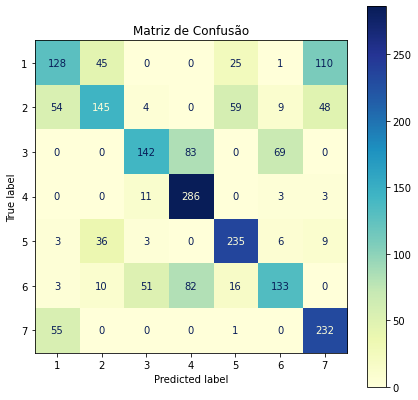

In [85]:
# Carregando o modelo
model = get_model()

# Alocando os atributos preditores na variável X
X = database.iloc[:,:-1]

# Alocando o atributo alvo na variável y
y = database.iloc[:,-1:]

# Definindo a partição holdout 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Treinando o modelo
model.fit(X_train, y_train)

# Construindo a matrix de confusão
fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(model, X_test, y_test, ax=ax, cmap='YlGnBu', values_format="")
plt.title('Matriz de Confusão')
plt.show()